In [6]:
from mne_bids import BIDSPath, write_raw_bids, get_anonymization_daysback
import random
import pandas as pd
import numpy as np
import itertools
import mne
import os
import sys
import re
from util.io.add_stream_to_event_tags import *
from util.io.remap_aux_labels import *
from util.io.iter_raw_paths import *

In [2]:
RAW_DIR = '../data/raw/'
BIDS_DIR = '../data/bids/'
MAPS_DIR = '../data/captrak/'

In [3]:
force = True

In [8]:
for fpath, sub, task, run in iter_raw_paths(RAW_DIR):
    print(fpath, sub, task, run)
    
    # Skip bad subs
    if sub in ["1", "20"]: # 20 wrong chan labels, 41-43 missing log files
        continue
    
    # Run only subs recorded on Recorder
    if int(sub) < 29:
        continue
    
    bids_path = BIDSPath(
        run = run,
        subject = sub,
        task = task,
        datatype = 'eeg',
        root = BIDS_DIR
    )
    vhdr_path = str(bids_path)
    
#     # Skip subs that are already converted
#     if os.path.exists(vhdr_path) & ~force:
#         print(f"{vhdr_path} already exists, skipping.")
#         continue

    # load data with MNE function for your file format
    full_fpath = os.path.join(RAW_DIR, fpath)
    print(full_fpath)
    raw = mne.io.read_raw_brainvision(full_fpath)
    raw.load_data()

    # Rename aux channels according to aux-label-remapping.csv
    print("Renaming aux channels")
    raw, remap_dict = remap_aux_labels(sub, raw, 'aux-label-remapping.csv')
    raw.rename_channels(remap_dict)
    raw.set_channel_types({'Left': 'stim', 'Right': 'stim'})
    raw.set_channel_types({'leog': 'eeg', 'reog': 'eeg'})

    # add some info BIDS will want
    print("Add line_freq to raw.info")
    raw.info['line_freq'] = 60 # the power line frequency in the building we collected in

    # map channel numbers to channel names
    print("Map channel numbers to channel names")
    print(f"Original channel names: {raw.ch_names}")
    if int(sub) < 29:
        map_fp = '../data/captrak/pitch_tracking_64_at_FCZ.csv'
        mapping_table = pd.read_csv(map_fp)
        mapping = {mapping_table.number[i]: mapping_table.name[i] for i in range(len(mapping_table))}
        raw.rename_channels(mapping)
    raw.add_reference_channels(ref_channels = ['Cz'])
    print(f"Channel names: {raw.ch_names}")

    # Checks
    n_channels = len(raw.ch_names)
    print(f"Number of channels: {n_channels}")
    if n_channels != 66:
        sys.exit(f"Incorrect number of channels, there should be 66 (2 aux incl) channels, instead there are {n_chans} channels")

    # Map channels to their coordinates
    print("Map channels to their captrak coordinates")
    captrak_found = False
    captrak_sub = sub

    while not captrak_found:
        print("Looking for captrak file")
        captrak_path = MAPS_DIR + 'sub-' + str(captrak_sub) + '.bvct'
        print(captrak_path)
        if os.path.isfile(captrak_path):
            print(f"Using captrak file from {captrak_sub}")
            dig = mne. channels.read_dig_captrak(captrak_path)
            raw.set_montage(dig, on_missing = 'warn')
            captrak_found = True
        else:
            captrak_sub = random.randint(3, 30)

    # Extract events from raw file
    print("Set annotations")
    events, event_ids = mne.events_from_annotations(raw)

    # Add stream to event tags
    events = add_stream_to_event_tags(events, sub)

    # Drop meaningless event name
    events = np.array(events)
    events = events[events[:,2] != event_ids['New Segment/'], :]

    # Rename events to their stimulus pitch
    annot = mne.annotations_from_events(events, sfreq = raw.info['sfreq'])
    raw.set_annotations(annot)

    # Get range of dates the BIDS specification will accept
    daysback_min, daysback_max = get_anonymization_daysback(raw)

    # Write data into BIDS directory, while anonymizing
    print("Write data into BIDS directory")
    write_raw_bids(
        raw,
        bids_path = bids_path,
        allow_preload = True, # whether to load full dataset into memory when copying
        format = 'BrainVision', # format to save to
        anonymize = dict(daysback = daysback_min), # shift dates by daysback
        overwrite = True,
    )

    # Check if conversion was successful and .vhdr file was written
    print(f".vhdr file written? {os.path.exists(vhdr_path)}")
    print("Done :-)")

sub-24.vhdr
sub-24.vhdr 24 dichotic 1
sub-40.vhdr
sub-40.vhdr 40 dichotic 1
../data/raw/sub-40.vhdr
Extracting parameters from ../data/raw/sub-40.vhdr...
Setting channel info structure...


/tmp/ipykernel_55889/2049025406.py:29: RuntimeWarning: No coordinate information found for channels ['leog', 'reog', 'Audio', 'Audio2']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = mne.io.read_raw_brainvision(full_fpath)
/tmp/ipykernel_55889/2049025406.py:29: RuntimeWarning: Not setting positions of 4 misc channels found in montage:
['leog', 'reog', 'Audio', 'Audio2']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = mne.io.read_raw_brainvision(full_fpath)


Reading 0 ... 16163699  =      0.000 ...  3232.740 secs...
Renaming aux channels
Add line_freq to raw.info
Map channel numbers to channel names
Original channel names: ['Fp1', 'Fz', 'F3', 'F7', 'FT9', 'FC5', 'FC1', 'C3', 'T7', 'TP9', 'CP5', 'CP1', 'Pz', 'P3', 'P7', 'O1', 'Oz', 'O2', 'P4', 'P8', 'TP10', 'CP6', 'CP2', 'C4', 'T8', 'FT10', 'FC6', 'FC2', 'F4', 'F8', 'Fp2', 'leog', 'AF3', 'AFz', 'F1', 'F5', 'FT7', 'FC3', 'C1', 'C5', 'TP7', 'CP3', 'P1', 'P5', 'PO7', 'PO3', 'POz', 'PO4', 'PO8', 'P6', 'P2', 'CPz', 'CP4', 'TP8', 'C6', 'C2', 'FC4', 'FT8', 'F6', 'reog', 'AF4', 'F2', 'FCz', 'Left', 'Right']


/tmp/ipykernel_55889/2049025406.py:37: RuntimeWarning: The unit for channel(s) leog, reog has changed from NA to V.
  raw.set_channel_types({'leog': 'eeg', 'reog': 'eeg'})
/tmp/ipykernel_55889/2049025406.py:51: RuntimeWarning: The locations of multiple reference channels are ignored.
  raw.add_reference_channels(ref_channels = ['Cz'])


Channel names: ['Fp1', 'Fz', 'F3', 'F7', 'FT9', 'FC5', 'FC1', 'C3', 'T7', 'TP9', 'CP5', 'CP1', 'Pz', 'P3', 'P7', 'O1', 'Oz', 'O2', 'P4', 'P8', 'TP10', 'CP6', 'CP2', 'C4', 'T8', 'FT10', 'FC6', 'FC2', 'F4', 'F8', 'Fp2', 'leog', 'AF3', 'AFz', 'F1', 'F5', 'FT7', 'FC3', 'C1', 'C5', 'TP7', 'CP3', 'P1', 'P5', 'PO7', 'PO3', 'POz', 'PO4', 'PO8', 'P6', 'P2', 'CPz', 'CP4', 'TP8', 'C6', 'C2', 'FC4', 'FT8', 'F6', 'reog', 'AF4', 'F2', 'FCz', 'Left', 'Right', 'Cz']
Number of channels: 66
Map channels to their captrak coordinates
Looking for captrak file
../data/captrak/sub-40.bvct
Looking for captrak file
../data/captrak/sub-26.bvct
Using captrak file from 26
Set annotations
Used Annotations descriptions: ['New Segment/', 'Stimulus/S 11', 'Stimulus/S 12', 'Stimulus/S 13', 'Stimulus/S 21', 'Stimulus/S 22', 'Stimulus/S 23', 'Stimulus/S 31', 'Stimulus/S 32', 'Stimulus/S 33']


/tmp/ipykernel_55889/2049025406.py:72: RuntimeWarning: DigMontage is only a subset of info. There are 2 channel positions not present in the DigMontage. The required channels are:

['leog', 'reog'].

Consider using inst.set_channel_types if these are not EEG channels, or use the on_missing parameter if the channel positions are allowed to be unknown in your analyses.
  raw.set_montage(dig, on_missing = 'warn')


../data/logs/sub-40_blk-3.log
../data/logs/sub-40_blk-4.log
../data/logs/sub-40_blk-2.log
../data/logs/sub-40_blk-0.log
../data/logs/sub-40_blk-1.log
Successfully matched marks and tags :-)
Write data into BIDS directory
Writing '../data/bids/participants.tsv'...
Writing '../data/bids/participants.json'...
Writing '../data/bids/sub-40/eeg/sub-40_space-CapTrak_electrodes.tsv'...
Writing '../data/bids/sub-40/eeg/sub-40_space-CapTrak_coordsystem.json'...
Used Annotations descriptions: ['111', '112', '113', '121', '122', '123', '131', '132', '133', '211', '212', '213', '221', '222', '223', '231', '232', '233']
Writing '../data/bids/sub-40/eeg/sub-40_task-dichotic_run-1_events.tsv'...
Writing '../data/bids/dataset_description.json'...
Writing '../data/bids/sub-40/eeg/sub-40_task-dichotic_run-1_eeg.json'...
Writing '../data/bids/sub-40/eeg/sub-40_task-dichotic_run-1_channels.tsv'...
Copying data files to sub-40_task-dichotic_run-1_eeg.vhdr


/tmp/ipykernel_55889/2049025406.py:97: RuntimeWarning: Converting data files to BrainVision format
  write_raw_bids(
/home/letitiayhho/.conda/envs/pitch-tracking/lib/python3.10/site-packages/pybv/io.py:394: UserWarning: Encountered unsupported non-voltage units: n/a
Note that the BrainVision format specification supports only µV.
  warn(msg)


Writing '../data/bids/sub-40/sub-40_scans.tsv'...
Wrote ../data/bids/sub-40/sub-40_scans.tsv entry with eeg/sub-40_task-dichotic_run-1_eeg.vhdr.
.vhdr file written? True
Done :-)
sub-1.vhdr
sub-1.vhdr 1 dichotic 1
sub-20.vhdr
sub-20.vhdr 20 dichotic 1
sub-41.vhdr
sub-41.vhdr 41 dichotic 1
../data/raw/sub-41.vhdr
Extracting parameters from ../data/raw/sub-41.vhdr...
Setting channel info structure...


/tmp/ipykernel_55889/2049025406.py:29: RuntimeWarning: No coordinate information found for channels ['leog', 'reog', 'right', 'left']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = mne.io.read_raw_brainvision(full_fpath)
/tmp/ipykernel_55889/2049025406.py:29: RuntimeWarning: Not setting positions of 4 misc channels found in montage:
['leog', 'reog', 'right', 'left']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = mne.io.read_raw_brainvision(full_fpath)


Reading 0 ... 16341299  =      0.000 ...  3268.260 secs...
Renaming aux channels
Add line_freq to raw.info
Map channel numbers to channel names
Original channel names: ['Fp1', 'Fz', 'F3', 'F7', 'FT9', 'FC5', 'FC1', 'C3', 'T7', 'TP9', 'CP5', 'CP1', 'Pz', 'P3', 'P7', 'O1', 'Oz', 'O2', 'P4', 'P8', 'TP10', 'CP6', 'CP2', 'C4', 'T8', 'FT10', 'FC6', 'FC2', 'F4', 'F8', 'Fp2', 'leog', 'AF3', 'AFz', 'F1', 'F5', 'FT7', 'FC3', 'C1', 'C5', 'TP7', 'CP3', 'P1', 'P5', 'PO7', 'PO3', 'POz', 'PO4', 'PO8', 'P6', 'P2', 'CPz', 'CP4', 'TP8', 'C6', 'C2', 'FC4', 'FT8', 'F6', 'reog', 'AF4', 'F2', 'FCz', 'Left', 'Right']


/tmp/ipykernel_55889/2049025406.py:37: RuntimeWarning: The unit for channel(s) leog, reog has changed from NA to V.
  raw.set_channel_types({'leog': 'eeg', 'reog': 'eeg'})
/tmp/ipykernel_55889/2049025406.py:51: RuntimeWarning: The locations of multiple reference channels are ignored.
  raw.add_reference_channels(ref_channels = ['Cz'])


Channel names: ['Fp1', 'Fz', 'F3', 'F7', 'FT9', 'FC5', 'FC1', 'C3', 'T7', 'TP9', 'CP5', 'CP1', 'Pz', 'P3', 'P7', 'O1', 'Oz', 'O2', 'P4', 'P8', 'TP10', 'CP6', 'CP2', 'C4', 'T8', 'FT10', 'FC6', 'FC2', 'F4', 'F8', 'Fp2', 'leog', 'AF3', 'AFz', 'F1', 'F5', 'FT7', 'FC3', 'C1', 'C5', 'TP7', 'CP3', 'P1', 'P5', 'PO7', 'PO3', 'POz', 'PO4', 'PO8', 'P6', 'P2', 'CPz', 'CP4', 'TP8', 'C6', 'C2', 'FC4', 'FT8', 'F6', 'reog', 'AF4', 'F2', 'FCz', 'Left', 'Right', 'Cz']
Number of channels: 66
Map channels to their captrak coordinates
Looking for captrak file
../data/captrak/sub-41.bvct
Looking for captrak file
../data/captrak/sub-9.bvct
Using captrak file from 9
Set annotations
Used Annotations descriptions: ['New Segment/', 'Stimulus/S 11', 'Stimulus/S 12', 'Stimulus/S 13', 'Stimulus/S 21', 'Stimulus/S 22', 'Stimulus/S 23', 'Stimulus/S 31', 'Stimulus/S 32', 'Stimulus/S 33']
../data/logs/sub-41_blk-4.log


/tmp/ipykernel_55889/2049025406.py:72: RuntimeWarning: DigMontage is only a subset of info. There are 2 channel positions not present in the DigMontage. The required channels are:

['leog', 'reog'].

Consider using inst.set_channel_types if these are not EEG channels, or use the on_missing parameter if the channel positions are allowed to be unknown in your analyses.
  raw.set_montage(dig, on_missing = 'warn')


../data/logs/sub-41_blk-0.log
../data/logs/sub-41_blk-3.log
../data/logs/sub-41_blk-2.log
../data/logs/sub-41_blk-1.log
Successfully matched marks and tags :-)
Write data into BIDS directory
Writing '../data/bids/participants.tsv'...
Writing '../data/bids/participants.json'...
Writing '../data/bids/sub-41/eeg/sub-41_space-CapTrak_electrodes.tsv'...
Writing '../data/bids/sub-41/eeg/sub-41_space-CapTrak_coordsystem.json'...
Used Annotations descriptions: ['111', '112', '113', '121', '122', '123', '131', '132', '133', '211', '212', '213', '221', '222', '223', '231', '232', '233']
Writing '../data/bids/sub-41/eeg/sub-41_task-dichotic_run-1_events.tsv'...
Writing '../data/bids/dataset_description.json'...
Writing '../data/bids/sub-41/eeg/sub-41_task-dichotic_run-1_eeg.json'...
Writing '../data/bids/sub-41/eeg/sub-41_task-dichotic_run-1_channels.tsv'...
Copying data files to sub-41_task-dichotic_run-1_eeg.vhdr


/tmp/ipykernel_55889/2049025406.py:97: RuntimeWarning: Converting data files to BrainVision format
  write_raw_bids(
/home/letitiayhho/.conda/envs/pitch-tracking/lib/python3.10/site-packages/pybv/io.py:394: UserWarning: Encountered unsupported non-voltage units: n/a
Note that the BrainVision format specification supports only µV.
  warn(msg)


Writing '../data/bids/sub-41/sub-41_scans.tsv'...
Wrote ../data/bids/sub-41/sub-41_scans.tsv entry with eeg/sub-41_task-dichotic_run-1_eeg.vhdr.
.vhdr file written? True
Done :-)
sub-30.vhdr
sub-30.vhdr 30 dichotic 1
../data/raw/sub-30.vhdr
Extracting parameters from ../data/raw/sub-30.vhdr...
Setting channel info structure...


/tmp/ipykernel_55889/2049025406.py:29: RuntimeWarning: No coordinate information found for channels ['leog', 'reog', 'Audio', 'Audio2']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = mne.io.read_raw_brainvision(full_fpath)
/tmp/ipykernel_55889/2049025406.py:29: RuntimeWarning: Not setting positions of 4 misc channels found in montage:
['leog', 'reog', 'Audio', 'Audio2']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = mne.io.read_raw_brainvision(full_fpath)


Reading 0 ... 20922699  =      0.000 ...  4184.540 secs...
Renaming aux channels
Add line_freq to raw.info
Map channel numbers to channel names
Original channel names: ['Fp1', 'Fz', 'F3', 'F7', 'FT9', 'FC5', 'FC1', 'C3', 'T7', 'TP9', 'CP5', 'CP1', 'Pz', 'P3', 'P7', 'O1', 'Oz', 'O2', 'P4', 'P8', 'TP10', 'CP6', 'CP2', 'C4', 'T8', 'FT10', 'FC6', 'FC2', 'F4', 'F8', 'Fp2', 'leog', 'AF3', 'AFz', 'F1', 'F5', 'FT7', 'FC3', 'C1', 'C5', 'TP7', 'CP3', 'P1', 'P5', 'PO7', 'PO3', 'POz', 'PO4', 'PO8', 'P6', 'P2', 'CPz', 'CP4', 'TP8', 'C6', 'C2', 'FC4', 'FT8', 'F6', 'reog', 'AF4', 'F2', 'FCz', 'Left', 'Right']


/tmp/ipykernel_55889/2049025406.py:37: RuntimeWarning: The unit for channel(s) leog, reog has changed from NA to V.
  raw.set_channel_types({'leog': 'eeg', 'reog': 'eeg'})
/tmp/ipykernel_55889/2049025406.py:51: RuntimeWarning: The locations of multiple reference channels are ignored.
  raw.add_reference_channels(ref_channels = ['Cz'])


Channel names: ['Fp1', 'Fz', 'F3', 'F7', 'FT9', 'FC5', 'FC1', 'C3', 'T7', 'TP9', 'CP5', 'CP1', 'Pz', 'P3', 'P7', 'O1', 'Oz', 'O2', 'P4', 'P8', 'TP10', 'CP6', 'CP2', 'C4', 'T8', 'FT10', 'FC6', 'FC2', 'F4', 'F8', 'Fp2', 'leog', 'AF3', 'AFz', 'F1', 'F5', 'FT7', 'FC3', 'C1', 'C5', 'TP7', 'CP3', 'P1', 'P5', 'PO7', 'PO3', 'POz', 'PO4', 'PO8', 'P6', 'P2', 'CPz', 'CP4', 'TP8', 'C6', 'C2', 'FC4', 'FT8', 'F6', 'reog', 'AF4', 'F2', 'FCz', 'Left', 'Right', 'Cz']
Number of channels: 66
Map channels to their captrak coordinates
Looking for captrak file
../data/captrak/sub-30.bvct
Looking for captrak file
../data/captrak/sub-30.bvct
Looking for captrak file
../data/captrak/sub-21.bvct
Using captrak file from 21
Set annotations
Used Annotations descriptions: ['New Segment/', 'Stimulus/S 11', 'Stimulus/S 12', 'Stimulus/S 13', 'Stimulus/S 21', 'Stimulus/S 22', 'Stimulus/S 23', 'Stimulus/S 31', 'Stimulus/S 32', 'Stimulus/S 33']
../data/logs/sub-30_blk-0.log


/tmp/ipykernel_55889/2049025406.py:72: RuntimeWarning: DigMontage is only a subset of info. There are 2 channel positions not present in the DigMontage. The required channels are:

['leog', 'reog'].

Consider using inst.set_channel_types if these are not EEG channels, or use the on_missing parameter if the channel positions are allowed to be unknown in your analyses.
  raw.set_montage(dig, on_missing = 'warn')


../data/logs/sub-30_blk-3.log
../data/logs/sub-30_blk-5.log
../data/logs/sub-30_blk-1.log
../data/logs/sub-30_blk-4.log
../data/logs/sub-30_blk-2.log
Successfully matched marks and tags :-)
Write data into BIDS directory
Writing '../data/bids/participants.tsv'...
Writing '../data/bids/participants.json'...
Writing '../data/bids/sub-30/eeg/sub-30_space-CapTrak_electrodes.tsv'...
Writing '../data/bids/sub-30/eeg/sub-30_space-CapTrak_coordsystem.json'...
Used Annotations descriptions: ['111', '112', '113', '121', '122', '123', '131', '132', '133', '211', '212', '213', '221', '222', '223', '231', '232', '233']
Writing '../data/bids/sub-30/eeg/sub-30_task-dichotic_run-1_events.tsv'...
Writing '../data/bids/dataset_description.json'...
Writing '../data/bids/sub-30/eeg/sub-30_task-dichotic_run-1_eeg.json'...
Writing '../data/bids/sub-30/eeg/sub-30_task-dichotic_run-1_channels.tsv'...
Copying data files to sub-30_task-dichotic_run-1_eeg.vhdr


/tmp/ipykernel_55889/2049025406.py:97: RuntimeWarning: Converting data files to BrainVision format
  write_raw_bids(
/home/letitiayhho/.conda/envs/pitch-tracking/lib/python3.10/site-packages/pybv/io.py:394: UserWarning: Encountered unsupported non-voltage units: n/a
Note that the BrainVision format specification supports only µV.
  warn(msg)


Writing '../data/bids/sub-30/sub-30_scans.tsv'...
Wrote ../data/bids/sub-30/sub-30_scans.tsv entry with eeg/sub-30_task-dichotic_run-1_eeg.vhdr.
.vhdr file written? True
Done :-)
sub-6.vhdr
sub-6.vhdr 6 dichotic 1
sub-42.vhdr
sub-42.vhdr 42 dichotic 1
../data/raw/sub-42.vhdr
Extracting parameters from ../data/raw/sub-42.vhdr...
Setting channel info structure...


/tmp/ipykernel_55889/2049025406.py:29: RuntimeWarning: No coordinate information found for channels ['leog', 'reog', 'right', 'left']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = mne.io.read_raw_brainvision(full_fpath)
/tmp/ipykernel_55889/2049025406.py:29: RuntimeWarning: Not setting positions of 4 misc channels found in montage:
['leog', 'reog', 'right', 'left']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = mne.io.read_raw_brainvision(full_fpath)


Reading 0 ... 17261399  =      0.000 ...  3452.280 secs...
Renaming aux channels
Add line_freq to raw.info
Map channel numbers to channel names
Original channel names: ['Fp1', 'Fz', 'F3', 'F7', 'FT9', 'FC5', 'FC1', 'C3', 'T7', 'TP9', 'CP5', 'CP1', 'Pz', 'P3', 'P7', 'O1', 'Oz', 'O2', 'P4', 'P8', 'TP10', 'CP6', 'CP2', 'C4', 'T8', 'FT10', 'FC6', 'FC2', 'F4', 'F8', 'Fp2', 'leog', 'AF3', 'AFz', 'F1', 'F5', 'FT7', 'FC3', 'C1', 'C5', 'TP7', 'CP3', 'P1', 'P5', 'PO7', 'PO3', 'POz', 'PO4', 'PO8', 'P6', 'P2', 'CPz', 'CP4', 'TP8', 'C6', 'C2', 'FC4', 'FT8', 'F6', 'reog', 'AF4', 'F2', 'FCz', 'Left', 'Right']


/tmp/ipykernel_55889/2049025406.py:37: RuntimeWarning: The unit for channel(s) leog, reog has changed from NA to V.
  raw.set_channel_types({'leog': 'eeg', 'reog': 'eeg'})
/tmp/ipykernel_55889/2049025406.py:51: RuntimeWarning: The locations of multiple reference channels are ignored.
  raw.add_reference_channels(ref_channels = ['Cz'])


Channel names: ['Fp1', 'Fz', 'F3', 'F7', 'FT9', 'FC5', 'FC1', 'C3', 'T7', 'TP9', 'CP5', 'CP1', 'Pz', 'P3', 'P7', 'O1', 'Oz', 'O2', 'P4', 'P8', 'TP10', 'CP6', 'CP2', 'C4', 'T8', 'FT10', 'FC6', 'FC2', 'F4', 'F8', 'Fp2', 'leog', 'AF3', 'AFz', 'F1', 'F5', 'FT7', 'FC3', 'C1', 'C5', 'TP7', 'CP3', 'P1', 'P5', 'PO7', 'PO3', 'POz', 'PO4', 'PO8', 'P6', 'P2', 'CPz', 'CP4', 'TP8', 'C6', 'C2', 'FC4', 'FT8', 'F6', 'reog', 'AF4', 'F2', 'FCz', 'Left', 'Right', 'Cz']
Number of channels: 66
Map channels to their captrak coordinates
Looking for captrak file
../data/captrak/sub-42.bvct
Looking for captrak file
../data/captrak/sub-28.bvct
Using captrak file from 28
Set annotations
Used Annotations descriptions: ['New Segment/', 'Stimulus/S 11', 'Stimulus/S 12', 'Stimulus/S 13', 'Stimulus/S 21', 'Stimulus/S 22', 'Stimulus/S 23', 'Stimulus/S 31', 'Stimulus/S 32', 'Stimulus/S 33']
../data/logs/sub-42_blk-0.log
../data/logs/sub-42_blk-1.log
../data/logs/sub-42_blk-2.log


/tmp/ipykernel_55889/2049025406.py:72: RuntimeWarning: DigMontage is only a subset of info. There are 2 channel positions not present in the DigMontage. The required channels are:

['leog', 'reog'].

Consider using inst.set_channel_types if these are not EEG channels, or use the on_missing parameter if the channel positions are allowed to be unknown in your analyses.
  raw.set_montage(dig, on_missing = 'warn')


../data/logs/sub-42_blk-5.log
../data/logs/sub-42_blk-4.log
../data/logs/sub-42_blk-3.log
Successfully matched marks and tags :-)
Write data into BIDS directory
Writing '../data/bids/participants.tsv'...
Writing '../data/bids/participants.json'...
Writing '../data/bids/sub-42/eeg/sub-42_space-CapTrak_electrodes.tsv'...
Writing '../data/bids/sub-42/eeg/sub-42_space-CapTrak_coordsystem.json'...
Used Annotations descriptions: ['111', '112', '113', '121', '122', '123', '131', '132', '133', '211', '212', '213', '221', '222', '223', '231', '232', '233']
Writing '../data/bids/sub-42/eeg/sub-42_task-dichotic_run-1_events.tsv'...
Writing '../data/bids/dataset_description.json'...
Writing '../data/bids/sub-42/eeg/sub-42_task-dichotic_run-1_eeg.json'...
Writing '../data/bids/sub-42/eeg/sub-42_task-dichotic_run-1_channels.tsv'...
Copying data files to sub-42_task-dichotic_run-1_eeg.vhdr


/tmp/ipykernel_55889/2049025406.py:97: RuntimeWarning: Converting data files to BrainVision format
  write_raw_bids(
/home/letitiayhho/.conda/envs/pitch-tracking/lib/python3.10/site-packages/pybv/io.py:394: UserWarning: Encountered unsupported non-voltage units: n/a
Note that the BrainVision format specification supports only µV.
  warn(msg)


Writing '../data/bids/sub-42/sub-42_scans.tsv'...
Wrote ../data/bids/sub-42/sub-42_scans.tsv entry with eeg/sub-42_task-dichotic_run-1_eeg.vhdr.
.vhdr file written? True
Done :-)
sub-38.vhdr
sub-38.vhdr 38 dichotic 1
../data/raw/sub-38.vhdr
Extracting parameters from ../data/raw/sub-38.vhdr...
Setting channel info structure...


/tmp/ipykernel_55889/2049025406.py:29: RuntimeWarning: No coordinate information found for channels ['leog', 'reog', 'Audio', 'Audio2']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = mne.io.read_raw_brainvision(full_fpath)
/tmp/ipykernel_55889/2049025406.py:29: RuntimeWarning: Not setting positions of 4 misc channels found in montage:
['leog', 'reog', 'Audio', 'Audio2']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = mne.io.read_raw_brainvision(full_fpath)


Reading 0 ... 18886199  =      0.000 ...  3777.240 secs...
Renaming aux channels
Add line_freq to raw.info
Map channel numbers to channel names
Original channel names: ['Fp1', 'Fz', 'F3', 'F7', 'FT9', 'FC5', 'FC1', 'C3', 'T7', 'TP9', 'CP5', 'CP1', 'Pz', 'P3', 'P7', 'O1', 'Oz', 'O2', 'P4', 'P8', 'TP10', 'CP6', 'CP2', 'C4', 'T8', 'FT10', 'FC6', 'FC2', 'F4', 'F8', 'Fp2', 'leog', 'AF3', 'AFz', 'F1', 'F5', 'FT7', 'FC3', 'C1', 'C5', 'TP7', 'CP3', 'P1', 'P5', 'PO7', 'PO3', 'POz', 'PO4', 'PO8', 'P6', 'P2', 'CPz', 'CP4', 'TP8', 'C6', 'C2', 'FC4', 'FT8', 'F6', 'reog', 'AF4', 'F2', 'FCz', 'Left', 'Right']


/tmp/ipykernel_55889/2049025406.py:37: RuntimeWarning: The unit for channel(s) leog, reog has changed from NA to V.
  raw.set_channel_types({'leog': 'eeg', 'reog': 'eeg'})
/tmp/ipykernel_55889/2049025406.py:51: RuntimeWarning: The locations of multiple reference channels are ignored.
  raw.add_reference_channels(ref_channels = ['Cz'])


Channel names: ['Fp1', 'Fz', 'F3', 'F7', 'FT9', 'FC5', 'FC1', 'C3', 'T7', 'TP9', 'CP5', 'CP1', 'Pz', 'P3', 'P7', 'O1', 'Oz', 'O2', 'P4', 'P8', 'TP10', 'CP6', 'CP2', 'C4', 'T8', 'FT10', 'FC6', 'FC2', 'F4', 'F8', 'Fp2', 'leog', 'AF3', 'AFz', 'F1', 'F5', 'FT7', 'FC3', 'C1', 'C5', 'TP7', 'CP3', 'P1', 'P5', 'PO7', 'PO3', 'POz', 'PO4', 'PO8', 'P6', 'P2', 'CPz', 'CP4', 'TP8', 'C6', 'C2', 'FC4', 'FT8', 'F6', 'reog', 'AF4', 'F2', 'FCz', 'Left', 'Right', 'Cz']
Number of channels: 66
Map channels to their captrak coordinates
Looking for captrak file
../data/captrak/sub-38.bvct
Looking for captrak file
../data/captrak/sub-23.bvct
Using captrak file from 23
Set annotations
Used Annotations descriptions: ['New Segment/', 'Stimulus/S 11', 'Stimulus/S 12', 'Stimulus/S 13', 'Stimulus/S 21', 'Stimulus/S 22', 'Stimulus/S 23', 'Stimulus/S 31', 'Stimulus/S 32', 'Stimulus/S 33']


/tmp/ipykernel_55889/2049025406.py:72: RuntimeWarning: DigMontage is only a subset of info. There are 2 channel positions not present in the DigMontage. The required channels are:

['leog', 'reog'].

Consider using inst.set_channel_types if these are not EEG channels, or use the on_missing parameter if the channel positions are allowed to be unknown in your analyses.
  raw.set_montage(dig, on_missing = 'warn')


../data/logs/sub-38_blk-0.log
../data/logs/sub-38_blk-4.log
../data/logs/sub-38_blk-1.log
../data/logs/sub-38_blk-2.log
../data/logs/sub-38_blk-3.log
../data/logs/sub-38_blk-5.log
Successfully matched marks and tags :-)
Write data into BIDS directory
Writing '../data/bids/participants.tsv'...
Writing '../data/bids/participants.json'...
Writing '../data/bids/sub-38/eeg/sub-38_space-CapTrak_electrodes.tsv'...
Writing '../data/bids/sub-38/eeg/sub-38_space-CapTrak_coordsystem.json'...
Used Annotations descriptions: ['111', '112', '113', '121', '122', '123', '131', '132', '133', '211', '212', '213', '221', '222', '223', '231', '232', '233']
Writing '../data/bids/sub-38/eeg/sub-38_task-dichotic_run-1_events.tsv'...
Writing '../data/bids/dataset_description.json'...
Writing '../data/bids/sub-38/eeg/sub-38_task-dichotic_run-1_eeg.json'...
Writing '../data/bids/sub-38/eeg/sub-38_task-dichotic_run-1_channels.tsv'...
Copying data files to sub-38_task-dichotic_run-1_eeg.vhdr


/tmp/ipykernel_55889/2049025406.py:97: RuntimeWarning: Converting data files to BrainVision format
  write_raw_bids(
/home/letitiayhho/.conda/envs/pitch-tracking/lib/python3.10/site-packages/pybv/io.py:394: UserWarning: Encountered unsupported non-voltage units: n/a
Note that the BrainVision format specification supports only µV.
  warn(msg)


Writing '../data/bids/sub-38/sub-38_scans.tsv'...
Wrote ../data/bids/sub-38/sub-38_scans.tsv entry with eeg/sub-38_task-dichotic_run-1_eeg.vhdr.
.vhdr file written? True
Done :-)
sub-33.vhdr
sub-33.vhdr 33 dichotic 1
../data/raw/sub-33.vhdr
Extracting parameters from ../data/raw/sub-33.vhdr...
Setting channel info structure...


/tmp/ipykernel_55889/2049025406.py:29: RuntimeWarning: No coordinate information found for channels ['leog', 'reog', 'Audio', 'Audio2']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = mne.io.read_raw_brainvision(full_fpath)
/tmp/ipykernel_55889/2049025406.py:29: RuntimeWarning: Not setting positions of 4 misc channels found in montage:
['leog', 'reog', 'Audio', 'Audio2']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = mne.io.read_raw_brainvision(full_fpath)


Reading 0 ... 16115399  =      0.000 ...  3223.080 secs...
Renaming aux channels
Add line_freq to raw.info
Map channel numbers to channel names
Original channel names: ['Fp1', 'Fz', 'F3', 'F7', 'FT9', 'FC5', 'FC1', 'C3', 'T7', 'TP9', 'CP5', 'CP1', 'Pz', 'P3', 'P7', 'O1', 'Oz', 'O2', 'P4', 'P8', 'TP10', 'CP6', 'CP2', 'C4', 'T8', 'FT10', 'FC6', 'FC2', 'F4', 'F8', 'Fp2', 'leog', 'AF3', 'AFz', 'F1', 'F5', 'FT7', 'FC3', 'C1', 'C5', 'TP7', 'CP3', 'P1', 'P5', 'PO7', 'PO3', 'POz', 'PO4', 'PO8', 'P6', 'P2', 'CPz', 'CP4', 'TP8', 'C6', 'C2', 'FC4', 'FT8', 'F6', 'reog', 'AF4', 'F2', 'FCz', 'Left', 'Right']


/tmp/ipykernel_55889/2049025406.py:37: RuntimeWarning: The unit for channel(s) leog, reog has changed from NA to V.
  raw.set_channel_types({'leog': 'eeg', 'reog': 'eeg'})
/tmp/ipykernel_55889/2049025406.py:51: RuntimeWarning: The locations of multiple reference channels are ignored.
  raw.add_reference_channels(ref_channels = ['Cz'])


Channel names: ['Fp1', 'Fz', 'F3', 'F7', 'FT9', 'FC5', 'FC1', 'C3', 'T7', 'TP9', 'CP5', 'CP1', 'Pz', 'P3', 'P7', 'O1', 'Oz', 'O2', 'P4', 'P8', 'TP10', 'CP6', 'CP2', 'C4', 'T8', 'FT10', 'FC6', 'FC2', 'F4', 'F8', 'Fp2', 'leog', 'AF3', 'AFz', 'F1', 'F5', 'FT7', 'FC3', 'C1', 'C5', 'TP7', 'CP3', 'P1', 'P5', 'PO7', 'PO3', 'POz', 'PO4', 'PO8', 'P6', 'P2', 'CPz', 'CP4', 'TP8', 'C6', 'C2', 'FC4', 'FT8', 'F6', 'reog', 'AF4', 'F2', 'FCz', 'Left', 'Right', 'Cz']
Number of channels: 66
Map channels to their captrak coordinates
Looking for captrak file
../data/captrak/sub-33.bvct
Looking for captrak file
../data/captrak/sub-14.bvct
Using captrak file from 14
Set annotations
Used Annotations descriptions: ['New Segment/', 'Stimulus/S 11', 'Stimulus/S 12', 'Stimulus/S 13', 'Stimulus/S 21', 'Stimulus/S 22', 'Stimulus/S 23', 'Stimulus/S 31', 'Stimulus/S 32', 'Stimulus/S 33']
../data/logs/sub-33_blk-4.log


/tmp/ipykernel_55889/2049025406.py:72: RuntimeWarning: DigMontage is only a subset of info. There are 2 channel positions not present in the DigMontage. The required channels are:

['leog', 'reog'].

Consider using inst.set_channel_types if these are not EEG channels, or use the on_missing parameter if the channel positions are allowed to be unknown in your analyses.
  raw.set_montage(dig, on_missing = 'warn')


../data/logs/sub-33_blk-0.log
../data/logs/sub-33_blk-3.log
../data/logs/sub-33_blk-2.log
../data/logs/sub-33_blk-1.log
Successfully matched marks and tags :-)
Write data into BIDS directory
Writing '../data/bids/participants.tsv'...
Writing '../data/bids/participants.json'...
Writing '../data/bids/sub-33/eeg/sub-33_space-CapTrak_electrodes.tsv'...
Writing '../data/bids/sub-33/eeg/sub-33_space-CapTrak_coordsystem.json'...
Used Annotations descriptions: ['111', '112', '113', '121', '122', '123', '131', '132', '133', '211', '212', '213', '221', '222', '223', '231', '232', '233']
Writing '../data/bids/sub-33/eeg/sub-33_task-dichotic_run-1_events.tsv'...
Writing '../data/bids/dataset_description.json'...
Writing '../data/bids/sub-33/eeg/sub-33_task-dichotic_run-1_eeg.json'...
Writing '../data/bids/sub-33/eeg/sub-33_task-dichotic_run-1_channels.tsv'...
Copying data files to sub-33_task-dichotic_run-1_eeg.vhdr


/tmp/ipykernel_55889/2049025406.py:97: RuntimeWarning: Converting data files to BrainVision format
  write_raw_bids(
/home/letitiayhho/.conda/envs/pitch-tracking/lib/python3.10/site-packages/pybv/io.py:394: UserWarning: Encountered unsupported non-voltage units: n/a
Note that the BrainVision format specification supports only µV.
  warn(msg)


Writing '../data/bids/sub-33/sub-33_scans.tsv'...
Wrote ../data/bids/sub-33/sub-33_scans.tsv entry with eeg/sub-33_task-dichotic_run-1_eeg.vhdr.
.vhdr file written? True
Done :-)
sub-35.vhdr
sub-35.vhdr 35 dichotic 1
../data/raw/sub-35.vhdr
Extracting parameters from ../data/raw/sub-35.vhdr...
Setting channel info structure...


/tmp/ipykernel_55889/2049025406.py:29: RuntimeWarning: No coordinate information found for channels ['leog', 'reog', 'Audio', 'Audio2']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = mne.io.read_raw_brainvision(full_fpath)
/tmp/ipykernel_55889/2049025406.py:29: RuntimeWarning: Not setting positions of 4 misc channels found in montage:
['leog', 'reog', 'Audio', 'Audio2']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = mne.io.read_raw_brainvision(full_fpath)


Reading 0 ... 19784399  =      0.000 ...  3956.880 secs...
Renaming aux channels
Add line_freq to raw.info
Map channel numbers to channel names
Original channel names: ['Fp1', 'Fz', 'F3', 'F7', 'FT9', 'FC5', 'FC1', 'C3', 'T7', 'TP9', 'CP5', 'CP1', 'Pz', 'P3', 'P7', 'O1', 'Oz', 'O2', 'P4', 'P8', 'TP10', 'CP6', 'CP2', 'C4', 'T8', 'FT10', 'FC6', 'FC2', 'F4', 'F8', 'Fp2', 'leog', 'AF3', 'AFz', 'F1', 'F5', 'FT7', 'FC3', 'C1', 'C5', 'TP7', 'CP3', 'P1', 'P5', 'PO7', 'PO3', 'POz', 'PO4', 'PO8', 'P6', 'P2', 'CPz', 'CP4', 'TP8', 'C6', 'C2', 'FC4', 'FT8', 'F6', 'reog', 'AF4', 'F2', 'FCz', 'Left', 'Right']


/tmp/ipykernel_55889/2049025406.py:37: RuntimeWarning: The unit for channel(s) leog, reog has changed from NA to V.
  raw.set_channel_types({'leog': 'eeg', 'reog': 'eeg'})
/tmp/ipykernel_55889/2049025406.py:51: RuntimeWarning: The locations of multiple reference channels are ignored.
  raw.add_reference_channels(ref_channels = ['Cz'])


Channel names: ['Fp1', 'Fz', 'F3', 'F7', 'FT9', 'FC5', 'FC1', 'C3', 'T7', 'TP9', 'CP5', 'CP1', 'Pz', 'P3', 'P7', 'O1', 'Oz', 'O2', 'P4', 'P8', 'TP10', 'CP6', 'CP2', 'C4', 'T8', 'FT10', 'FC6', 'FC2', 'F4', 'F8', 'Fp2', 'leog', 'AF3', 'AFz', 'F1', 'F5', 'FT7', 'FC3', 'C1', 'C5', 'TP7', 'CP3', 'P1', 'P5', 'PO7', 'PO3', 'POz', 'PO4', 'PO8', 'P6', 'P2', 'CPz', 'CP4', 'TP8', 'C6', 'C2', 'FC4', 'FT8', 'F6', 'reog', 'AF4', 'F2', 'FCz', 'Left', 'Right', 'Cz']
Number of channels: 66
Map channels to their captrak coordinates
Looking for captrak file
../data/captrak/sub-35.bvct
Looking for captrak file
../data/captrak/sub-7.bvct
Looking for captrak file
../data/captrak/sub-30.bvct
Looking for captrak file
../data/captrak/sub-24.bvct
Using captrak file from 24
Set annotations
Used Annotations descriptions: ['New Segment/', 'Stimulus/S 11', 'Stimulus/S 12', 'Stimulus/S 13', 'Stimulus/S 21', 'Stimulus/S 22', 'Stimulus/S 23', 'Stimulus/S 31', 'Stimulus/S 32', 'Stimulus/S 33']


/tmp/ipykernel_55889/2049025406.py:72: RuntimeWarning: DigMontage is only a subset of info. There are 2 channel positions not present in the DigMontage. The required channels are:

['leog', 'reog'].

Consider using inst.set_channel_types if these are not EEG channels, or use the on_missing parameter if the channel positions are allowed to be unknown in your analyses.
  raw.set_montage(dig, on_missing = 'warn')


../data/logs/sub-35_blk-3.log
../data/logs/sub-35_blk-1.log
../data/logs/sub-35_blk-4.log
../data/logs/sub-35_blk-2.log
../data/logs/sub-35_blk-5.log
../data/logs/sub-35_blk-0.log
Successfully matched marks and tags :-)
Write data into BIDS directory
Writing '../data/bids/participants.tsv'...
Writing '../data/bids/participants.json'...
Writing '../data/bids/sub-35/eeg/sub-35_space-CapTrak_electrodes.tsv'...
Writing '../data/bids/sub-35/eeg/sub-35_space-CapTrak_coordsystem.json'...
Used Annotations descriptions: ['111', '112', '113', '121', '122', '123', '131', '132', '133', '211', '212', '213', '221', '222', '223', '231', '232', '233']
Writing '../data/bids/sub-35/eeg/sub-35_task-dichotic_run-1_events.tsv'...
Writing '../data/bids/dataset_description.json'...
Writing '../data/bids/sub-35/eeg/sub-35_task-dichotic_run-1_eeg.json'...
Writing '../data/bids/sub-35/eeg/sub-35_task-dichotic_run-1_channels.tsv'...
Copying data files to sub-35_task-dichotic_run-1_eeg.vhdr


/tmp/ipykernel_55889/2049025406.py:97: RuntimeWarning: Converting data files to BrainVision format
  write_raw_bids(
/home/letitiayhho/.conda/envs/pitch-tracking/lib/python3.10/site-packages/pybv/io.py:394: UserWarning: Encountered unsupported non-voltage units: n/a
Note that the BrainVision format specification supports only µV.
  warn(msg)


Writing '../data/bids/sub-35/sub-35_scans.tsv'...
Wrote ../data/bids/sub-35/sub-35_scans.tsv entry with eeg/sub-35_task-dichotic_run-1_eeg.vhdr.
.vhdr file written? True
Done :-)
sub-8.vhdr
sub-8.vhdr 8 dichotic 1
sub-43.vhdr
sub-43.vhdr 43 dichotic 1
../data/raw/sub-43.vhdr
Extracting parameters from ../data/raw/sub-43.vhdr...
Setting channel info structure...


/tmp/ipykernel_55889/2049025406.py:29: RuntimeWarning: No coordinate information found for channels ['leog', 'reog', 'right', 'left']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = mne.io.read_raw_brainvision(full_fpath)
/tmp/ipykernel_55889/2049025406.py:29: RuntimeWarning: Not setting positions of 4 misc channels found in montage:
['leog', 'reog', 'right', 'left']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = mne.io.read_raw_brainvision(full_fpath)


Reading 0 ... 19007399  =      0.000 ...  3801.480 secs...
Renaming aux channels
Add line_freq to raw.info
Map channel numbers to channel names
Original channel names: ['Fp1', 'Fz', 'F3', 'F7', 'FT9', 'FC5', 'FC1', 'C3', 'T7', 'TP9', 'CP5', 'CP1', 'Pz', 'P3', 'P7', 'O1', 'Oz', 'O2', 'P4', 'P8', 'TP10', 'CP6', 'CP2', 'C4', 'T8', 'FT10', 'FC6', 'FC2', 'F4', 'F8', 'Fp2', 'leog', 'AF3', 'AFz', 'F1', 'F5', 'FT7', 'FC3', 'C1', 'C5', 'TP7', 'CP3', 'P1', 'P5', 'PO7', 'PO3', 'POz', 'PO4', 'PO8', 'P6', 'P2', 'CPz', 'CP4', 'TP8', 'C6', 'C2', 'FC4', 'FT8', 'F6', 'reog', 'AF4', 'F2', 'FCz', 'Left', 'Right']


/tmp/ipykernel_55889/2049025406.py:37: RuntimeWarning: The unit for channel(s) leog, reog has changed from NA to V.
  raw.set_channel_types({'leog': 'eeg', 'reog': 'eeg'})
/tmp/ipykernel_55889/2049025406.py:51: RuntimeWarning: The locations of multiple reference channels are ignored.
  raw.add_reference_channels(ref_channels = ['Cz'])


Channel names: ['Fp1', 'Fz', 'F3', 'F7', 'FT9', 'FC5', 'FC1', 'C3', 'T7', 'TP9', 'CP5', 'CP1', 'Pz', 'P3', 'P7', 'O1', 'Oz', 'O2', 'P4', 'P8', 'TP10', 'CP6', 'CP2', 'C4', 'T8', 'FT10', 'FC6', 'FC2', 'F4', 'F8', 'Fp2', 'leog', 'AF3', 'AFz', 'F1', 'F5', 'FT7', 'FC3', 'C1', 'C5', 'TP7', 'CP3', 'P1', 'P5', 'PO7', 'PO3', 'POz', 'PO4', 'PO8', 'P6', 'P2', 'CPz', 'CP4', 'TP8', 'C6', 'C2', 'FC4', 'FT8', 'F6', 'reog', 'AF4', 'F2', 'FCz', 'Left', 'Right', 'Cz']
Number of channels: 66
Map channels to their captrak coordinates
Looking for captrak file
../data/captrak/sub-43.bvct
Looking for captrak file
../data/captrak/sub-6.bvct
Using captrak file from 6
Set annotations
Used Annotations descriptions: ['New Segment/', 'Stimulus/S 11', 'Stimulus/S 12', 'Stimulus/S 13', 'Stimulus/S 21', 'Stimulus/S 22', 'Stimulus/S 23', 'Stimulus/S 31', 'Stimulus/S 32', 'Stimulus/S 33']
../data/logs/sub-43_blk-3.log


/tmp/ipykernel_55889/2049025406.py:72: RuntimeWarning: DigMontage is only a subset of info. There are 2 channel positions not present in the DigMontage. The required channels are:

['leog', 'reog'].

Consider using inst.set_channel_types if these are not EEG channels, or use the on_missing parameter if the channel positions are allowed to be unknown in your analyses.
  raw.set_montage(dig, on_missing = 'warn')


../data/logs/sub-43_blk-2.log
../data/logs/sub-43_blk-4.log
../data/logs/sub-43_blk-0.log
../data/logs/sub-43_blk-1.log
Successfully matched marks and tags :-)
Write data into BIDS directory
Writing '../data/bids/participants.tsv'...
Writing '../data/bids/participants.json'...
Writing '../data/bids/sub-43/eeg/sub-43_space-CapTrak_electrodes.tsv'...
Writing '../data/bids/sub-43/eeg/sub-43_space-CapTrak_coordsystem.json'...
Used Annotations descriptions: ['111', '112', '113', '121', '122', '123', '131', '132', '133', '211', '212', '213', '221', '222', '223', '231', '232', '233']
Writing '../data/bids/sub-43/eeg/sub-43_task-dichotic_run-1_events.tsv'...
Writing '../data/bids/dataset_description.json'...
Writing '../data/bids/sub-43/eeg/sub-43_task-dichotic_run-1_eeg.json'...
Writing '../data/bids/sub-43/eeg/sub-43_task-dichotic_run-1_channels.tsv'...
Copying data files to sub-43_task-dichotic_run-1_eeg.vhdr


/tmp/ipykernel_55889/2049025406.py:97: RuntimeWarning: Converting data files to BrainVision format
  write_raw_bids(
/home/letitiayhho/.conda/envs/pitch-tracking/lib/python3.10/site-packages/pybv/io.py:394: UserWarning: Encountered unsupported non-voltage units: n/a
Note that the BrainVision format specification supports only µV.
  warn(msg)


Writing '../data/bids/sub-43/sub-43_scans.tsv'...
Wrote ../data/bids/sub-43/sub-43_scans.tsv entry with eeg/sub-43_task-dichotic_run-1_eeg.vhdr.
.vhdr file written? True
Done :-)
sub-25.vhdr
sub-25.vhdr 25 dichotic 1
sub-9.vhdr
sub-9.vhdr 9 dichotic 1
sub-11.vhdr
sub-11.vhdr 11 dichotic 1
sub-14.vhdr
sub-14.vhdr 14 dichotic 1
sub-4.vhdr
sub-4.vhdr 4 dichotic 1
sub-5.vhdr
sub-5.vhdr 5 dichotic 1
sub-29.vhdr
sub-29.vhdr 29 dichotic 1
../data/raw/sub-29.vhdr
Extracting parameters from ../data/raw/sub-29.vhdr...
Setting channel info structure...


/tmp/ipykernel_55889/2049025406.py:29: RuntimeWarning: No coordinate information found for channels ['leog', 'reog', 'Audio', 'Audio2']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = mne.io.read_raw_brainvision(full_fpath)
/tmp/ipykernel_55889/2049025406.py:29: RuntimeWarning: Not setting positions of 4 misc channels found in montage:
['leog', 'reog', 'Audio', 'Audio2']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = mne.io.read_raw_brainvision(full_fpath)


Reading 0 ... 19300199  =      0.000 ...  3860.040 secs...
Renaming aux channels
Add line_freq to raw.info
Map channel numbers to channel names
Original channel names: ['Fp1', 'Fz', 'F3', 'F7', 'FT9', 'FC5', 'FC1', 'C3', 'T7', 'TP9', 'CP5', 'CP1', 'Pz', 'P3', 'P7', 'O1', 'Oz', 'O2', 'P4', 'P8', 'TP10', 'CP6', 'CP2', 'C4', 'T8', 'FT10', 'FC6', 'FC2', 'F4', 'F8', 'Fp2', 'leog', 'AF3', 'AFz', 'F1', 'F5', 'FT7', 'FC3', 'C1', 'C5', 'TP7', 'CP3', 'P1', 'P5', 'PO7', 'PO3', 'POz', 'PO4', 'PO8', 'P6', 'P2', 'CPz', 'CP4', 'TP8', 'C6', 'C2', 'FC4', 'FT8', 'F6', 'reog', 'AF4', 'F2', 'FCz', 'Left', 'Right']


/tmp/ipykernel_55889/2049025406.py:37: RuntimeWarning: The unit for channel(s) leog, reog has changed from NA to V.
  raw.set_channel_types({'leog': 'eeg', 'reog': 'eeg'})
/tmp/ipykernel_55889/2049025406.py:51: RuntimeWarning: The locations of multiple reference channels are ignored.
  raw.add_reference_channels(ref_channels = ['Cz'])


Channel names: ['Fp1', 'Fz', 'F3', 'F7', 'FT9', 'FC5', 'FC1', 'C3', 'T7', 'TP9', 'CP5', 'CP1', 'Pz', 'P3', 'P7', 'O1', 'Oz', 'O2', 'P4', 'P8', 'TP10', 'CP6', 'CP2', 'C4', 'T8', 'FT10', 'FC6', 'FC2', 'F4', 'F8', 'Fp2', 'leog', 'AF3', 'AFz', 'F1', 'F5', 'FT7', 'FC3', 'C1', 'C5', 'TP7', 'CP3', 'P1', 'P5', 'PO7', 'PO3', 'POz', 'PO4', 'PO8', 'P6', 'P2', 'CPz', 'CP4', 'TP8', 'C6', 'C2', 'FC4', 'FT8', 'F6', 'reog', 'AF4', 'F2', 'FCz', 'Left', 'Right', 'Cz']
Number of channels: 66
Map channels to their captrak coordinates
Looking for captrak file
../data/captrak/sub-29.bvct
Using captrak file from 29
Set annotations
Used Annotations descriptions: ['New Segment/', 'Stimulus/S 11', 'Stimulus/S 12', 'Stimulus/S 13', 'Stimulus/S 21', 'Stimulus/S 22', 'Stimulus/S 23', 'Stimulus/S 31', 'Stimulus/S 32', 'Stimulus/S 33']


/tmp/ipykernel_55889/2049025406.py:72: RuntimeWarning: DigMontage is only a subset of info. There are 2 channel positions not present in the DigMontage. The required channels are:

['leog', 'reog'].

Consider using inst.set_channel_types if these are not EEG channels, or use the on_missing parameter if the channel positions are allowed to be unknown in your analyses.
  raw.set_montage(dig, on_missing = 'warn')


../data/logs/sub-29_blk-1.log
../data/logs/sub-29_blk-2.log
../data/logs/sub-29_blk-3.log
../data/logs/sub-29_blk-4.log
../data/logs/sub-29_blk-0.log
Successfully matched marks and tags :-)
Write data into BIDS directory
Writing '../data/bids/participants.tsv'...
Writing '../data/bids/participants.json'...
Writing '../data/bids/sub-29/eeg/sub-29_space-CapTrak_electrodes.tsv'...
Writing '../data/bids/sub-29/eeg/sub-29_space-CapTrak_coordsystem.json'...
Used Annotations descriptions: ['111', '112', '113', '121', '122', '123', '131', '132', '133', '211', '212', '213', '221', '222', '223', '231', '232', '233']
Writing '../data/bids/sub-29/eeg/sub-29_task-dichotic_run-1_events.tsv'...
Writing '../data/bids/dataset_description.json'...
Writing '../data/bids/sub-29/eeg/sub-29_task-dichotic_run-1_eeg.json'...
Writing '../data/bids/sub-29/eeg/sub-29_task-dichotic_run-1_channels.tsv'...
Copying data files to sub-29_task-dichotic_run-1_eeg.vhdr


/tmp/ipykernel_55889/2049025406.py:97: RuntimeWarning: Converting data files to BrainVision format
  write_raw_bids(
/home/letitiayhho/.conda/envs/pitch-tracking/lib/python3.10/site-packages/pybv/io.py:394: UserWarning: Encountered unsupported non-voltage units: n/a
Note that the BrainVision format specification supports only µV.
  warn(msg)


Writing '../data/bids/sub-29/sub-29_scans.tsv'...
Wrote ../data/bids/sub-29/sub-29_scans.tsv entry with eeg/sub-29_task-dichotic_run-1_eeg.vhdr.
.vhdr file written? True
Done :-)
sub-31.vhdr
sub-31.vhdr 31 dichotic 1
../data/raw/sub-31.vhdr
Extracting parameters from ../data/raw/sub-31.vhdr...
Setting channel info structure...


/tmp/ipykernel_55889/2049025406.py:29: RuntimeWarning: No coordinate information found for channels ['leog', 'reog', 'Audio', 'Audio2']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = mne.io.read_raw_brainvision(full_fpath)
/tmp/ipykernel_55889/2049025406.py:29: RuntimeWarning: Not setting positions of 4 misc channels found in montage:
['leog', 'reog', 'Audio', 'Audio2']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = mne.io.read_raw_brainvision(full_fpath)


Reading 0 ... 17559499  =      0.000 ...  3511.900 secs...
Renaming aux channels
Add line_freq to raw.info
Map channel numbers to channel names
Original channel names: ['Fp1', 'Fz', 'F3', 'F7', 'FT9', 'FC5', 'FC1', 'C3', 'T7', 'TP9', 'CP5', 'CP1', 'Pz', 'P3', 'P7', 'O1', 'Oz', 'O2', 'P4', 'P8', 'TP10', 'CP6', 'CP2', 'C4', 'T8', 'FT10', 'FC6', 'FC2', 'F4', 'F8', 'Fp2', 'leog', 'AF3', 'AFz', 'F1', 'F5', 'FT7', 'FC3', 'C1', 'C5', 'TP7', 'CP3', 'P1', 'P5', 'PO7', 'PO3', 'POz', 'PO4', 'PO8', 'P6', 'P2', 'CPz', 'CP4', 'TP8', 'C6', 'C2', 'FC4', 'FT8', 'F6', 'reog', 'AF4', 'F2', 'FCz', 'Left', 'Right']


/tmp/ipykernel_55889/2049025406.py:37: RuntimeWarning: The unit for channel(s) leog, reog has changed from NA to V.
  raw.set_channel_types({'leog': 'eeg', 'reog': 'eeg'})
/tmp/ipykernel_55889/2049025406.py:51: RuntimeWarning: The locations of multiple reference channels are ignored.
  raw.add_reference_channels(ref_channels = ['Cz'])


Channel names: ['Fp1', 'Fz', 'F3', 'F7', 'FT9', 'FC5', 'FC1', 'C3', 'T7', 'TP9', 'CP5', 'CP1', 'Pz', 'P3', 'P7', 'O1', 'Oz', 'O2', 'P4', 'P8', 'TP10', 'CP6', 'CP2', 'C4', 'T8', 'FT10', 'FC6', 'FC2', 'F4', 'F8', 'Fp2', 'leog', 'AF3', 'AFz', 'F1', 'F5', 'FT7', 'FC3', 'C1', 'C5', 'TP7', 'CP3', 'P1', 'P5', 'PO7', 'PO3', 'POz', 'PO4', 'PO8', 'P6', 'P2', 'CPz', 'CP4', 'TP8', 'C6', 'C2', 'FC4', 'FT8', 'F6', 'reog', 'AF4', 'F2', 'FCz', 'Left', 'Right', 'Cz']
Number of channels: 66
Map channels to their captrak coordinates
Looking for captrak file
../data/captrak/sub-31.bvct
Looking for captrak file
../data/captrak/sub-27.bvct
Using captrak file from 27
Set annotations
Used Annotations descriptions: ['New Segment/', 'Stimulus/S 11', 'Stimulus/S 12', 'Stimulus/S 13', 'Stimulus/S 21', 'Stimulus/S 22', 'Stimulus/S 23', 'Stimulus/S 31', 'Stimulus/S 32', 'Stimulus/S 33']


/tmp/ipykernel_55889/2049025406.py:72: RuntimeWarning: DigMontage is only a subset of info. There are 2 channel positions not present in the DigMontage. The required channels are:

['leog', 'reog'].

Consider using inst.set_channel_types if these are not EEG channels, or use the on_missing parameter if the channel positions are allowed to be unknown in your analyses.
  raw.set_montage(dig, on_missing = 'warn')


../data/logs/sub-31_blk-4.log
../data/logs/sub-31_blk-3.log
../data/logs/sub-31_blk-1.log
../data/logs/sub-31_blk-0.log
../data/logs/sub-31_blk-2.log
Successfully matched marks and tags :-)
Write data into BIDS directory
Writing '../data/bids/participants.tsv'...
Writing '../data/bids/participants.json'...
Writing '../data/bids/sub-31/eeg/sub-31_space-CapTrak_electrodes.tsv'...
Writing '../data/bids/sub-31/eeg/sub-31_space-CapTrak_coordsystem.json'...
Used Annotations descriptions: ['111', '112', '113', '121', '122', '123', '131', '132', '133', '211', '212', '213', '221', '222', '223', '231', '232', '233']
Writing '../data/bids/sub-31/eeg/sub-31_task-dichotic_run-1_events.tsv'...
Writing '../data/bids/dataset_description.json'...
Writing '../data/bids/sub-31/eeg/sub-31_task-dichotic_run-1_eeg.json'...
Writing '../data/bids/sub-31/eeg/sub-31_task-dichotic_run-1_channels.tsv'...
Copying data files to sub-31_task-dichotic_run-1_eeg.vhdr


/tmp/ipykernel_55889/2049025406.py:97: RuntimeWarning: Converting data files to BrainVision format
  write_raw_bids(
/home/letitiayhho/.conda/envs/pitch-tracking/lib/python3.10/site-packages/pybv/io.py:394: UserWarning: Encountered unsupported non-voltage units: n/a
Note that the BrainVision format specification supports only µV.
  warn(msg)


Writing '../data/bids/sub-31/sub-31_scans.tsv'...
Wrote ../data/bids/sub-31/sub-31_scans.tsv entry with eeg/sub-31_task-dichotic_run-1_eeg.vhdr.
.vhdr file written? True
Done :-)
sub-39.vhdr
sub-39.vhdr 39 dichotic 1
../data/raw/sub-39.vhdr
Extracting parameters from ../data/raw/sub-39.vhdr...
Setting channel info structure...


/tmp/ipykernel_55889/2049025406.py:29: RuntimeWarning: No coordinate information found for channels ['leog', 'reog', 'Audio', 'Audio2']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = mne.io.read_raw_brainvision(full_fpath)
/tmp/ipykernel_55889/2049025406.py:29: RuntimeWarning: Not setting positions of 4 misc channels found in montage:
['leog', 'reog', 'Audio', 'Audio2']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = mne.io.read_raw_brainvision(full_fpath)


Reading 0 ... 17757399  =      0.000 ...  3551.480 secs...
Renaming aux channels
Add line_freq to raw.info
Map channel numbers to channel names
Original channel names: ['Fp1', 'Fz', 'F3', 'F7', 'FT9', 'FC5', 'FC1', 'C3', 'T7', 'TP9', 'CP5', 'CP1', 'Pz', 'P3', 'P7', 'O1', 'Oz', 'O2', 'P4', 'P8', 'TP10', 'CP6', 'CP2', 'C4', 'T8', 'FT10', 'FC6', 'FC2', 'F4', 'F8', 'Fp2', 'leog', 'AF3', 'AFz', 'F1', 'F5', 'FT7', 'FC3', 'C1', 'C5', 'TP7', 'CP3', 'P1', 'P5', 'PO7', 'PO3', 'POz', 'PO4', 'PO8', 'P6', 'P2', 'CPz', 'CP4', 'TP8', 'C6', 'C2', 'FC4', 'FT8', 'F6', 'reog', 'AF4', 'F2', 'FCz', 'Left', 'Right']


/tmp/ipykernel_55889/2049025406.py:37: RuntimeWarning: The unit for channel(s) leog, reog has changed from NA to V.
  raw.set_channel_types({'leog': 'eeg', 'reog': 'eeg'})
/tmp/ipykernel_55889/2049025406.py:51: RuntimeWarning: The locations of multiple reference channels are ignored.
  raw.add_reference_channels(ref_channels = ['Cz'])


Channel names: ['Fp1', 'Fz', 'F3', 'F7', 'FT9', 'FC5', 'FC1', 'C3', 'T7', 'TP9', 'CP5', 'CP1', 'Pz', 'P3', 'P7', 'O1', 'Oz', 'O2', 'P4', 'P8', 'TP10', 'CP6', 'CP2', 'C4', 'T8', 'FT10', 'FC6', 'FC2', 'F4', 'F8', 'Fp2', 'leog', 'AF3', 'AFz', 'F1', 'F5', 'FT7', 'FC3', 'C1', 'C5', 'TP7', 'CP3', 'P1', 'P5', 'PO7', 'PO3', 'POz', 'PO4', 'PO8', 'P6', 'P2', 'CPz', 'CP4', 'TP8', 'C6', 'C2', 'FC4', 'FT8', 'F6', 'reog', 'AF4', 'F2', 'FCz', 'Left', 'Right', 'Cz']
Number of channels: 66
Map channels to their captrak coordinates
Looking for captrak file
../data/captrak/sub-39.bvct
Looking for captrak file
../data/captrak/sub-26.bvct
Using captrak file from 26
Set annotations
Used Annotations descriptions: ['New Segment/', 'Stimulus/S 11', 'Stimulus/S 12', 'Stimulus/S 13', 'Stimulus/S 21', 'Stimulus/S 22', 'Stimulus/S 23', 'Stimulus/S 31', 'Stimulus/S 32', 'Stimulus/S 33']
../data/logs/sub-39_blk-2.log


/tmp/ipykernel_55889/2049025406.py:72: RuntimeWarning: DigMontage is only a subset of info. There are 2 channel positions not present in the DigMontage. The required channels are:

['leog', 'reog'].

Consider using inst.set_channel_types if these are not EEG channels, or use the on_missing parameter if the channel positions are allowed to be unknown in your analyses.
  raw.set_montage(dig, on_missing = 'warn')


../data/logs/sub-39_blk-3.log
../data/logs/sub-39_blk-1.log
../data/logs/sub-39_blk-4.log
../data/logs/sub-39_blk-0.log
Successfully matched marks and tags :-)
Write data into BIDS directory
Writing '../data/bids/participants.tsv'...
Writing '../data/bids/participants.json'...
Writing '../data/bids/sub-39/eeg/sub-39_space-CapTrak_electrodes.tsv'...
Writing '../data/bids/sub-39/eeg/sub-39_space-CapTrak_coordsystem.json'...
Used Annotations descriptions: ['111', '112', '113', '121', '122', '123', '131', '132', '133', '211', '212', '213', '221', '222', '223', '231', '232', '233']
Writing '../data/bids/sub-39/eeg/sub-39_task-dichotic_run-1_events.tsv'...
Writing '../data/bids/dataset_description.json'...
Writing '../data/bids/sub-39/eeg/sub-39_task-dichotic_run-1_eeg.json'...
Writing '../data/bids/sub-39/eeg/sub-39_task-dichotic_run-1_channels.tsv'...
Copying data files to sub-39_task-dichotic_run-1_eeg.vhdr


/tmp/ipykernel_55889/2049025406.py:97: RuntimeWarning: Converting data files to BrainVision format
  write_raw_bids(
/home/letitiayhho/.conda/envs/pitch-tracking/lib/python3.10/site-packages/pybv/io.py:394: UserWarning: Encountered unsupported non-voltage units: n/a
Note that the BrainVision format specification supports only µV.
  warn(msg)


Writing '../data/bids/sub-39/sub-39_scans.tsv'...
Wrote ../data/bids/sub-39/sub-39_scans.tsv entry with eeg/sub-39_task-dichotic_run-1_eeg.vhdr.
.vhdr file written? True
Done :-)


In [10]:
len(ch_names)

65

In [ ]:
from mne_bids import BIDSPath, write_raw_bids, get_anonymization_daysback
import random
import pandas as pd
import numpy as np
import itertools
import mne
import os
import sys
import re
from util.io.get_chan_mapping import get_chan_mapping
from util.io.add_stream_to_event_tags import *
from util.io.iter_raw_paths import iter_raw_paths

In [2]:
RAW_DIR = '../data/raw/'
BIDS_DIR = '../data/bids/'
MAPS_DIR = '../data/captrak/'

In [4]:
for (fpath, sub, task, run) in iter_raw_paths(RAW_DIR):
    if int(sub) > 28:
        break

sub-24.vhdr
sub-40.vhdr


In [ ]:
fpath = RAW_DIR + fpath
raw = mne.io.read_raw_brainvision(fpath)
raw.load_data()

Extracting parameters from ../data/raw/sub-40.vhdr...
Setting channel info structure...


/tmp/ipykernel_48807/3452802452.py:2: RuntimeWarning: No coordinate information found for channels ['leog', 'reog', 'Audio', 'Audio2']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = mne.io.read_raw_brainvision(fpath)
/tmp/ipykernel_48807/3452802452.py:2: RuntimeWarning: Not setting positions of 4 misc channels found in montage:
['leog', 'reog', 'Audio', 'Audio2']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = mne.io.read_raw_brainvision(fpath)


Reading 0 ... 16163699  =      0.000 ...  3232.740 secs...


In [ ]:
remapping = pd.read_csv('aux-label-remapping.csv')
remapping

In [4]:
fpath = '../data/raw/sub-40.vhdr'

In [44]:
# load data with MNE function for your file format
print(fpath)
raw = mne.io.read_raw_brainvision(fpath)
raw.load_data()
if int(sub) < 29:
    aux_names = ['Left', 'Right']
    raw.rename_channels({'Audio': 'Right', 'Audio2': 'Left'})

    raw.set_channel_types({'Left': 'eeg', 'Right': 'eeg'})
    raw.pick_channels(aux_names)
elif 29 <= int(sub) < 41:
    aux_names = ['Audio', 'Audio2']
    raw.set_channel_types({'Audio': 'eeg', 'Audio2': 'eeg'})
    raw.pick_channels(aux_names)
elif int(sub) >= 41:
    aux_names = ['left', 'right']
    raw.set_channel_types({'left': 'eeg', 'right': 'eeg'})
    raw.pick_channels(aux_names)
return raw, aux_names
raw.set_channel_types({'Left': 'eeg', 'Right': 'eeg', 'reog': 'eog', 'leog': 'eog'})
raw.pick_channels(["Left", "Right"])

../data/raw/sub-40.vhdr
Extracting parameters from ../data/raw/sub-40.vhdr...
Setting channel info structure...


/tmp/ipykernel_30743/4153386870.py:3: RuntimeWarning: No coordinate information found for channels ['leog', 'reog', 'Audio', 'Audio2']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = mne.io.read_raw_brainvision(fpath)
/tmp/ipykernel_30743/4153386870.py:3: RuntimeWarning: Not setting positions of 4 misc channels found in montage:
['leog', 'reog', 'Audio', 'Audio2']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = mne.io.read_raw_brainvision(fpath)


Reading 0 ... 16163699  =      0.000 ...  3232.740 secs...


/tmp/ipykernel_30743/4153386870.py:6: RuntimeWarning: The unit for channel(s) Left, Right, leog, reog has changed from NA to V.
  raw.set_channel_types({'Left': 'eeg', 'Right': 'eeg', 'reog': 'eog', 'leog': 'eog'})


<RawBrainVision | sub-40.eeg, 2 x 16163700 (3232.7 s), ~246.7 MB, data loaded>

In [14]:
# add some info BIDS will want
print("Add line_freq to raw.info")
raw.info['line_freq'] = 60 # the power line frequency in the building we collected in

Add line_freq to raw.info


In [20]:
# Extract events from raw file
print("Set annotations")
events, event_ids = mne.events_from_annotations(raw)
events

Set annotations
Used Annotations descriptions: ['New Segment/', 'Stimulus/S 11', 'Stimulus/S 12', 'Stimulus/S 13', 'Stimulus/S 21', 'Stimulus/S 22', 'Stimulus/S 23', 'Stimulus/S 31', 'Stimulus/S 32', 'Stimulus/S 33']


array([[       0,        0,    99999],
       [   97295,        0,       32],
       [  103054,        0,       11],
       ...,
       [16117404,        0,       32],
       [16123169,        0,       31],
       [16128933,        0,       22]])

Not setting metadata
1801 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 244 events and 4001 original time points ...
0 bad epochs dropped
    Using multitaper spectrum estimation with 7 DPSS windows


/tmp/ipykernel_30743/239966647.py:10: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  epochs['32'].plot_psd(picks = 'eeg')


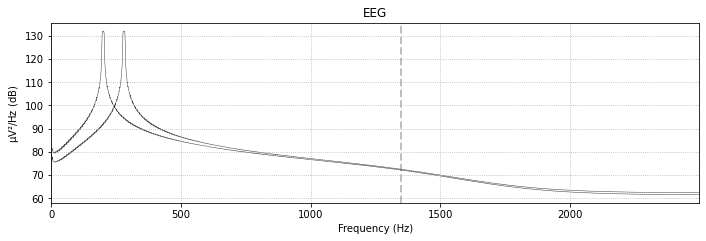

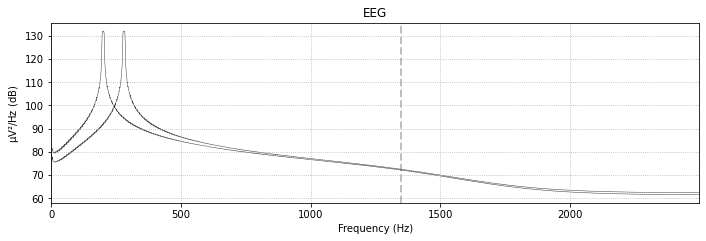

In [45]:
# Plot aux channels and match with event labels
epochs = mne.Epochs(raw, events, tmin = -0.4, tmax = .4, baseline = (-0.4, 0))
# fig = epochs.plot(picks = 'Aux1', events = 11)
# raw.plot(block=True, events=events, duration = 2, start = 97)
# epochs.plot(picks = 'stim', n_epochs=1, events = events)


# Plot psd by event tag and psd at each stim channel
# epochs["32"].compute_psd().plot(picks="stim")
epochs['32'].plot_psd(picks = 'eeg')

# Add units to data?

# Look at channel names?
# raw.info['ch_names']

In [7]:
# map channel numbers to channel names
print("Map channel numbers to channel names")
mapping = get_chan_mapping(MAPS_DIR, sub)
raw.rename_channels(mapping)
raw.add_reference_channels(ref_channels = ['Cz'])

Map channel numbers to channel names


ValueError: Invalid channel name(s) {'Ch34', 'Ch47', 'Ch37', 'Ch20', 'Ch59', 'Ch10', 'Ch42', 'Ch53', 'Ch31', 'Ch61', 'Ch56', 'Ch7', 'Ch49', 'Ch55', 'Ch62', 'Ch18', 'Ch11', 'Ch28', 'Ch54', 'Ch27', 'Ch64', 'Ch35', 'Ch17', 'Ch57', 'Ch19', 'Ch15', 'Ch30', 'Ch48', 'Ch63', 'Ch5', 'Ch9', 'Ch40', 'Ch44', 'Ch60', 'Ch13', 'Ch16', 'Ch22', 'Ch1', 'Ch26', 'Ch29', 'Ch32', 'Ch38', 'Ch50', 'Ch46', 'Ch21', 'Ch36', 'Ch4', 'Ch51', 'Ch58', 'Ch8', 'Ch33', 'Ch52', 'Ch25', 'Ch43', 'Ch12', 'Ch3', 'Ch45', 'Ch6', 'Ch14', 'Ch23', 'Ch2', 'Ch41', 'Ch39'} are not present in info

In [7]:
# Checks
if len(raw.ch_names) != 66:
    sys.exit(f"Incorrect number of channels, there should be 66 (2 aux incl) channels, instead there are {n_chans} channels")

In [8]:
# Map channels to their coordinates
print("Map channels to their captrak coordinates")
captrak_found = False
captrak_sub = sub

while not captrak_found:
    print("Looking for captrak file")
    captrak_path = MAPS_DIR + 'sub-' + str(captrak_sub) + '.bvct'
    print(captrak_path)
    if os.path.isfile(captrak_path):
        print(f"Using captrak file from {captrak_sub}")
        dig = mne. channels.read_dig_captrak(captrak_path)
        raw.set_montage(dig, on_missing = 'warn')
        captrak_found = True
    else:
        captrak_sub = random.randint(3, 30)

Map channels to their captrak coordinates
Looking for captrak file
../data/captrak/sub-24.bvct
Using captrak file from 24


/tmp/ipykernel_26915/3384685196.py:13: RuntimeWarning: DigMontage is only a subset of info. There are 2 channel positions not present in the DigMontage. The required channels are:

['leog', 'reog'].

Consider using inst.set_channel_types if these are not EEG channels, or use the on_missing parameter if the channel positions are allowed to be unknown in your analyses.
  raw.set_montage(dig, on_missing = 'warn')


In [28]:
# Add stream to event tags
events = add_stream_to_event_tags(events, sub)

# Drop meaningless event name
events = np.array(events)
events = events[events[:,2] != event_ids['New Segment/'], :]

../data/logs/sub-24_blk-2.log
../data/logs/sub-24_blk-4.log
../data/logs/sub-24_blk-0.log
../data/logs/sub-24_blk-1.log
../data/logs/sub-24_blk-3.log
Successfully matched marks and tags :-)


In [29]:
# Rename events to their stimulus pitch
annot = mne.annotations_from_events(events, sfreq = raw.info['sfreq'])
raw.set_annotations(annot)

<RawBrainVision | sub-24.eeg, 66 x 17303500 (3460.7 s), ~8.51 GB, data loaded>

In [30]:
# Get range of dates the BIDS specification will accept
daysback_min, daysback_max = get_anonymization_daysback(raw)

In [31]:
# Write data into BIDS directory, while anonymizing
print("Write data into BIDS directory")
bids_path = BIDSPath(
        run = run,
        subject = sub,
        task = task,
        datatype = 'eeg',
        root = BIDS_DIR
)

write_raw_bids(
    raw,
    bids_path = bids_path,
    allow_preload = True, # whether to load full dataset into memory when copying
    format = 'BrainVision', # format to save to
    anonymize = dict(daysback = daysback_min), # shift dates by daysback
    overwrite = True,
)

Write data into BIDS directory
Writing '../data/bids/README'...
Writing '../data/bids/participants.tsv'...
Writing '../data/bids/participants.json'...
Writing '../data/bids/sub-24/eeg/sub-24_space-CapTrak_electrodes.tsv'...
Writing '../data/bids/sub-24/eeg/sub-24_space-CapTrak_coordsystem.json'...
Used Annotations descriptions: ['111', '112', '113', '121', '122', '123', '131', '132', '133', '211', '212', '213', '221', '222', '223', '231', '232', '233']
Writing '../data/bids/sub-24/eeg/sub-24_task-pitch_run-1_events.tsv'...
Writing '../data/bids/dataset_description.json'...
Writing '../data/bids/sub-24/eeg/sub-24_task-pitch_run-1_eeg.json'...
Writing '../data/bids/sub-24/eeg/sub-24_task-pitch_run-1_channels.tsv'...
Copying data files to sub-24_task-pitch_run-1_eeg.vhdr


/tmp/ipykernel_26915/1538107732.py:11: RuntimeWarning: Converting data files to BrainVision format
  write_raw_bids(
/home/letitiayhho/.conda/envs/pitch-tracking/lib/python3.10/site-packages/pybv/io.py:394: UserWarning: Encountered unsupported non-voltage units: n/a
Note that the BrainVision format specification supports only µV.
  warn(msg)


Writing '../data/bids/sub-24/sub-24_scans.tsv'...
Wrote ../data/bids/sub-24/sub-24_scans.tsv entry with eeg/sub-24_task-pitch_run-1_eeg.vhdr.


BIDSPath(
root: ../data/bids
datatype: eeg
basename: sub-24_task-pitch_run-1_eeg.vhdr)